In [12]:
import matplotlib.pyplot as plt
from aerobot.utils import RESULTS_PATH, load_results_dict, DATA_PATH, FIGURES_PATH, CONTIGS_PATH
from aerobot.plot import plot_configure_mpl, PRETTY_NAMES
from aerobot.dataset import FeatureDataset
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
from Bio import SeqIO
import os
from typing import List, Dict, Tuple
import scipy.optimize
import glob 

%load_ext autoreload 
%autoreload 2 

plot_configure_mpl(figure_height=2) # Want at least one color for each genome have results for. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
CONTIGS_PATH = os.path.join(DATA_PATH, 'contigs')
# These are the feature types which I currently have results for. 
feature_types = ['nt_3mer', 'nt_4mer', 'nt_5mer']

In [14]:
# Want to get the final model accuracies for adding to the titles. 
test_accs = dict()
for feature_type in feature_types:
    results = load_results_dict(os.path.join(RESULTS_PATH, f'train_nonlinear_{feature_type}_ternary.json'))
    test_acc = results['test_acc']
    print(f'Final testing accuracy for {feature_type}: {test_acc}')
    test_accs[feature_type] = int(test_acc * 100)

Final testing accuracy for nt_3mer: 0.7226179739211519
Final testing accuracy for nt_4mer: 0.7846858812892107
Final testing accuracy for nt_5mer: 0.7860711537775603


In [15]:
def parse_contig_id(contig_id:str) -> Dict:
    '''Parse a contig ID, which is of the form {genome_id}_{contig_size}_{contig_number}'''

    genome_id_prefix, genome_id_num, contig_size, contig_num = contig_id.split('_')
    contig_size = int(contig_size)
    genome_id = f'{genome_id_prefix}_{genome_id_num}'
    return {'id':contig_id, 'contig_size':contig_size, 'genome_id':genome_id}

In [16]:
# Load the correct labels for each genome, as well as other metadata. Use the metadata stored in the datasets,
# as this contains extra information (like contig size).
genome_metadata = pd.read_csv(os.path.join(CONTIGS_PATH, 'genome_metadata.csv'), index_col=0)
genome_metadata['genome_id'] = genome_metadata.index
# Organize the contigs results into DataFrames for plotting. 
contigs_results = dict() 

for feature_type in feature_types:
    predictions = pd.read_csv(os.path.join(RESULTS_PATH, f'predict_contigs_nonlinear_{feature_type}_ternary.csv'), index_col=0)
    metadata = pd.DataFrame([parse_contig_id(contig_id) for contig_id in predictions.index])
    metadata = metadata.merge(genome_metadata, on='genome_id', how='left')
    metadata = metadata.set_index('id')

    predictions = predictions.merge(metadata, how='left', left_index=True, right_index=True)
    # We want to assess contig predictions based on the whole-genome predictions. 
    # "correct" column indicates whether or not the contig prediction matches the genome prediction. 
    predictions['correct'] = predictions.prediction == predictions[f'{feature_type}_prediction']
    # predictions['correct'] = predictions.prediction == predictions.physiology.str.lower()
    contigs_results[feature_type] = predictions


In [17]:
nt_5mer_results = contigs_results['nt_5mer']
print('Number of aerobes:', np.sum(nt_5mer_results.physiology.str.match('Aerobe')))
print('Number of facultative:', np.sum(nt_5mer_results.physiology.str.match('Facultative')))
print('Number of anaerobes:', np.sum(nt_5mer_results.physiology.str.match('Anaerobe')))
print()
print('Number of aerobes:', np.sum(nt_5mer_results.physiology.str.match('Aerobe')) / len(nt_5mer_results))
print('Number of facultative:', np.sum(nt_5mer_results.physiology.str.match('Facultative')) / len(nt_5mer_results))
print('Number of anaerobes:', np.sum(nt_5mer_results.physiology.str.match('Anaerobe')) / len(nt_5mer_results))

Number of aerobes: 12309
Number of facultative: 1671
Number of anaerobes: 8435

Number of aerobes: 0.549141200089226
Number of facultative: 0.07454829355342404
Number of anaerobes: 0.37631050635734997


In [18]:
genome_sizes = []
# Get the average size of the downloaded genomes. 
for file in os.listdir(os.path.join(CONTIGS_PATH, 'genomes')):
    genome = [str(record.seq) for record in SeqIO.parse(os.path.join(CONTIGS_PATH, 'genomes', file), 'fasta')]
    genome = ''.join(genome)
    genome_sizes.append(len(genome))
print('Mean genome size:', np.mean(genome_sizes))


Mean genome size: 3762205.180579216


In [19]:
from sklearn.metrics import balanced_accuracy_score

for contig_size, contig_size_df in contigs_results['nt_4mer'].groupby('contig_size'):
    labels = contig_size_df.physiology.str.lower().values
    y_pred = contig_size_df.prediction.values 

    print(f'Balanced accuracy score for contigs of size {contig_size}:', balanced_accuracy_score(labels, y_pred))

    for label, label_df in contig_size_df.groupby('physiology'):
        label = label.lower()
        y_pred = label_df.prediction.values
        print(f'\tAccuracy on {label}:', np.sum(y_pred == label) / len(label_df))

Balanced accuracy score for contigs of size 2000: 0.6259389213775178
	Accuracy on aerobe: 0.6051851851851852
	Accuracy on anaerobe: 0.7626315789473684
	Accuracy on facultative: 0.51
Balanced accuracy score for contigs of size 5000: 0.6768486029889539
	Accuracy on aerobe: 0.6737037037037037
	Accuracy on anaerobe: 0.8068421052631579
	Accuracy on facultative: 0.55
Balanced accuracy score for contigs of size 10000: 0.7210455709949212
	Accuracy on aerobe: 0.7135958395245171
	Accuracy on anaerobe: 0.8431578947368421
	Accuracy on facultative: 0.6063829787234043
Balanced accuracy score for contigs of size 20000: 0.7572901613055264
	Accuracy on aerobe: 0.776663993584603
	Accuracy on anaerobe: 0.8729154686601495
	Accuracy on facultative: 0.6222910216718266
Balanced accuracy score for contigs of size 50000: 0.8293494854762669
	Accuracy on aerobe: 0.8374927452118398
	Accuracy on anaerobe: 0.8714859437751004
	Accuracy on facultative: 0.7790697674418605


# SI Figure 7 


In [22]:
def plot_si_figure_6(contigs_results:Dict[str, pd.DataFrame], fig:plt.Figure=None, grids:List[GridSpec]=None):
    '''Plot the results of evaluating trained Nonlinear classifiers on contigs. The contigs are generated using closed
    genomes from the testing dataset, for which we have known labels.'''
    axes = []
    for i, feature_type in enumerate(feature_types):
        ax = fig.add_subplot(grids[i])

        # Extract the results for the specified feature type. 
        results = contigs_results[feature_type]
        
        labels, handles = [],[]
        # Group the results according to the true label of the genome...
        for label, label_df in results.groupby('physiology'):
            labels.append(label.lower())
            
            x_vals, y_vals = [], []
            for contig_size in results.contig_size.unique():
                contig_size_df = label_df[label_df.contig_size == contig_size]
                x_vals.append(contig_size)
                y_vals.append(contig_size_df.correct.mean())
                errs = contig_size_df.correct.std() / np.sqrt(len(contig_size_df))
            # x_vals.append(3000000)
            # y_vals.append(1)
            ax.errorbar(x_vals, y_vals, yerr=errs, lw=0.7)
            handles.append(ax.scatter(x_vals, y_vals, s=10, linewidths=0.2))
            
        ax.set_xlabel('contig size')
        ax.set_yticks(np.arange(0.3, 1.0, 0.1), labels=[str(np.round(i, 2)) for i in np.arange(0.3, 1.0, 0.1)]) # Make tick labels consistent across plots.
        ax.set_ylabel('fraction matching genome prediction')
        ax.set_title(PRETTY_NAMES[feature_type] + f' ({test_accs[feature_type]}%)')
        axes.append(ax)
    
    axes[0].legend(handles=handles, labels=labels, loc='lower right')
        
    return axes # Return the axes for plotting the A, B, C labels. 



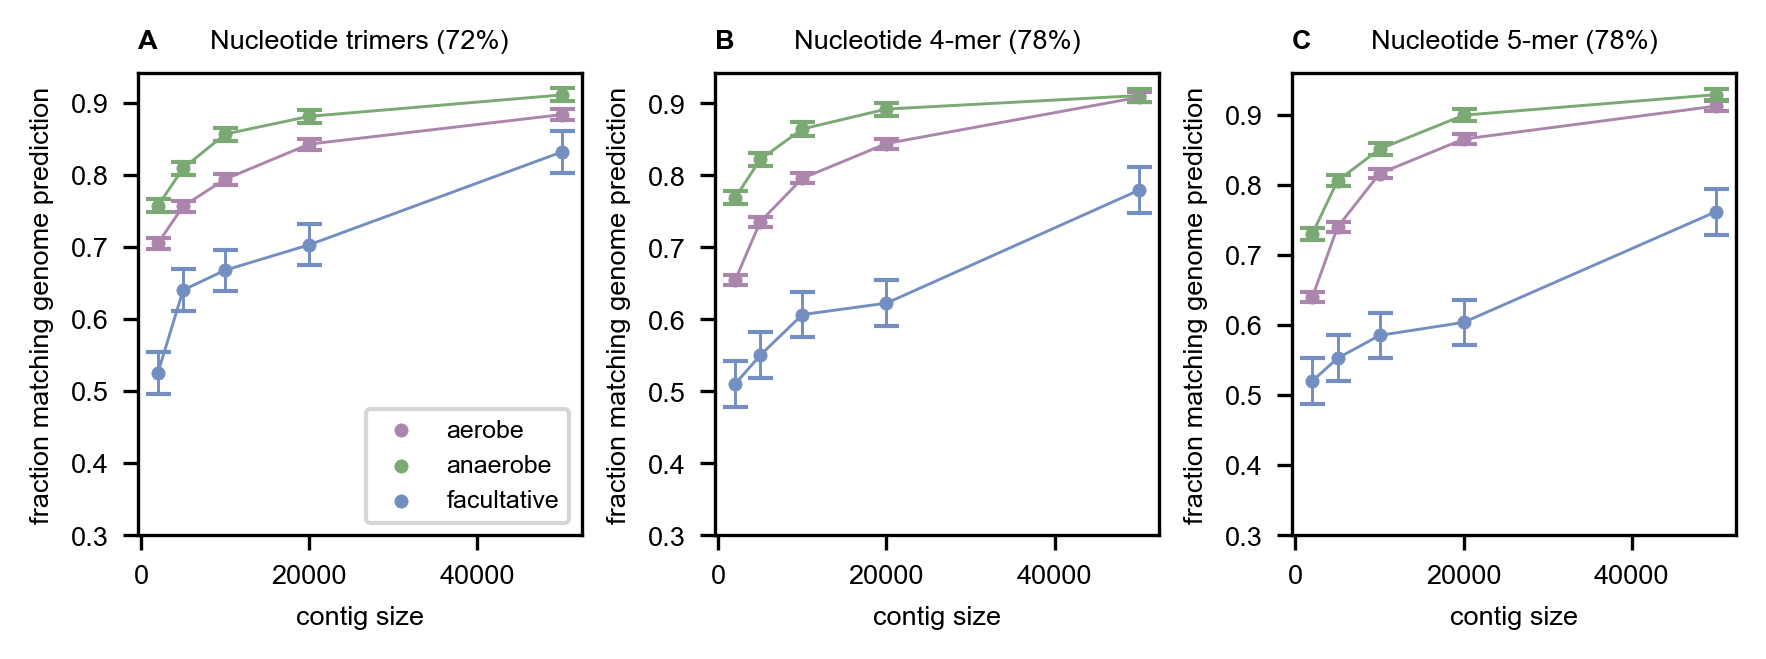

In [23]:
# n_rows, n_cols = 2, 3
n_cols = 3
fig = plt.figure()

grids = GridSpec(1, n_cols, wspace=0.3)
grids = [grids[0, i] for i in range(n_cols)] # + [grids[1, i] for i in range(n_cols)]

axes = plot_si_figure_6(contigs_results, fig=fig, grids=grids)

for ax, ax_label in zip(axes, 'ABC'):
    ax.set_title(ax_label, loc='left', fontweight='bold')

plt.savefig(os.path.join(FIGURES_PATH, 'si_fig7.png'), dpi=300, facecolor='w', bbox_inches='tight')
plt.show()